# Phase 1: Distance Threshold Analysis

Analyzes experiment results to determine an optimal cosine distance cutoff for filtering
retrieved memories. The goal is to increase **precision** (reduce false positives) while
maintaining acceptable **recall** (not losing ground truth memories).

All analysis is at the **per-memory level** — deduplicated by memory ID, using the *best* (minimum)
distance across all queries. This reflects production behavior: a memory is "found" if *any* query
retrieves it.

**Approach:**
1. Collect best-distance data per unique memory
2. Visualize distributions (ground truth vs non-ground-truth)
3. Sweep thresholds and compute precision/recall/F1
4. Identify the optimal cutoff and its tradeoffs

In [14]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

RESULTS_DIR = Path("data/phase1/results")

# Load all experiment result files
result_files = sorted(RESULTS_DIR.glob("results_*.json"))
print(f"Project root: {PROJECT_ROOT}")
print(f"Found {len(result_files)} result files:")
for f in result_files:
    print(f"  {f.name}")

Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Found 11 result files:
  results_tc_review_10_exp_20260202_180709.json
  results_tc_review_11_exp_20260202_180723.json
  results_tc_review_1_exp_20260202_180652.json
  results_tc_review_2_exp_20260202_180739.json
  results_tc_review_3_exp_20260202_180755.json
  results_tc_review_4_exp_20260202_180811.json
  results_tc_review_5_exp_20260202_180830.json
  results_tc_review_6_exp_20260202_180843.json
  results_tc_review_7_exp_20260202_180858.json
  results_tc_review_8_exp_20260202_180915.json
  results_tc_review_9_exp_20260202_180936.json


In [15]:
# Build per-unique-memory data: best (minimum) distance for each memory across all queries
experiments = []
for f in result_files:
    with open(f) as fh:
        experiments.append(json.load(fh))

gt_best_distances = []     # best distance per GT memory (across all experiments)
non_gt_best_distances = [] # best distance per non-GT memory
gt_memory_details = []     # (memory_id, best_distance, experiment_id)

for exp in experiments:
    tc_id = exp.get("test_case_id", "unknown")
    gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))

    best_distances = {}
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r["distance"]
            if mid not in best_distances or d < best_distances[mid]:
                best_distances[mid] = d

    for mid, d in best_distances.items():
        if mid in gt_ids:
            gt_best_distances.append(d)
            gt_memory_details.append((mid, d, tc_id))
        else:
            non_gt_best_distances.append(d)

gt_best = np.array(gt_best_distances)
non_gt_best = np.array(non_gt_best_distances)

# Count GT memories NOT retrieved at all
total_gt_memories = sum(len(exp.get("ground_truth", {}).get("memory_ids", [])) for exp in experiments)
not_retrieved = total_gt_memories - len(gt_best)

print(f"Unique memories retrieved across all experiments:")
print(f"  GT memories retrieved:     {len(gt_best)} / {total_gt_memories}")
print(f"  GT memories NOT retrieved: {not_retrieved}")
print(f"  Non-GT memories:           {len(non_gt_best)}")
print(f"\nGT best-distance range:     [{gt_best.min():.4f}, {gt_best.max():.4f}]")
print(f"Non-GT best-distance range: [{non_gt_best.min():.4f}, {non_gt_best.max():.4f}]")
print(f"\nGT mean: {gt_best.mean():.4f}, median: {np.median(gt_best):.4f}")
print(f"Non-GT mean: {non_gt_best.mean():.4f}, median: {np.median(non_gt_best):.4f}")

print(f"\nPer GT memory details (sorted by distance):")
for mid, d, tc in sorted(gt_memory_details, key=lambda x: x[1]):
    print(f"  {d:.4f}  {mid}  ({tc})")

Unique memories retrieved across all experiments:
  GT memories retrieved:     41 / 41
  GT memories NOT retrieved: 0
  Non-GT memories:           355

GT best-distance range:     [0.2194, 0.9605]
Non-GT best-distance range: [0.6193, 1.0498]

GT mean: 0.6422, median: 0.6163
Non-GT mean: 0.9052, median: 0.9115

Per GT memory details (sorted by distance):
  0.2194  mem_6f362f1d6808  (tc_review_4)
  0.4162  mem_819630bee3db  (tc_review_11)
  0.4218  mem_788f1dcfbb8c  (tc_review_5)
  0.4580  mem_80962cfd2f56  (tc_review_7)
  0.4604  mem_b09708770b0e  (tc_review_11)
  0.4692  mem_47f0c280ca8f  (tc_review_10)
  0.5191  mem_cc83c544db09  (tc_review_8)
  0.5257  mem_52c300d9d6dc  (tc_review_10)
  0.5348  mem_638ce08683ad  (tc_review_1)
  0.5386  mem_dec07d36f54c  (tc_review_8)
  0.5449  mem_337f95b5d490  (tc_review_7)
  0.5450  mem_0171a029889c  (tc_review_9)
  0.5505  mem_ddb0fa4f5e2c  (tc_review_1)
  0.5544  mem_bb5267a2e339  (tc_review_8)
  0.5652  mem_d14ca46cce40  (tc_review_11)
  0.5804 

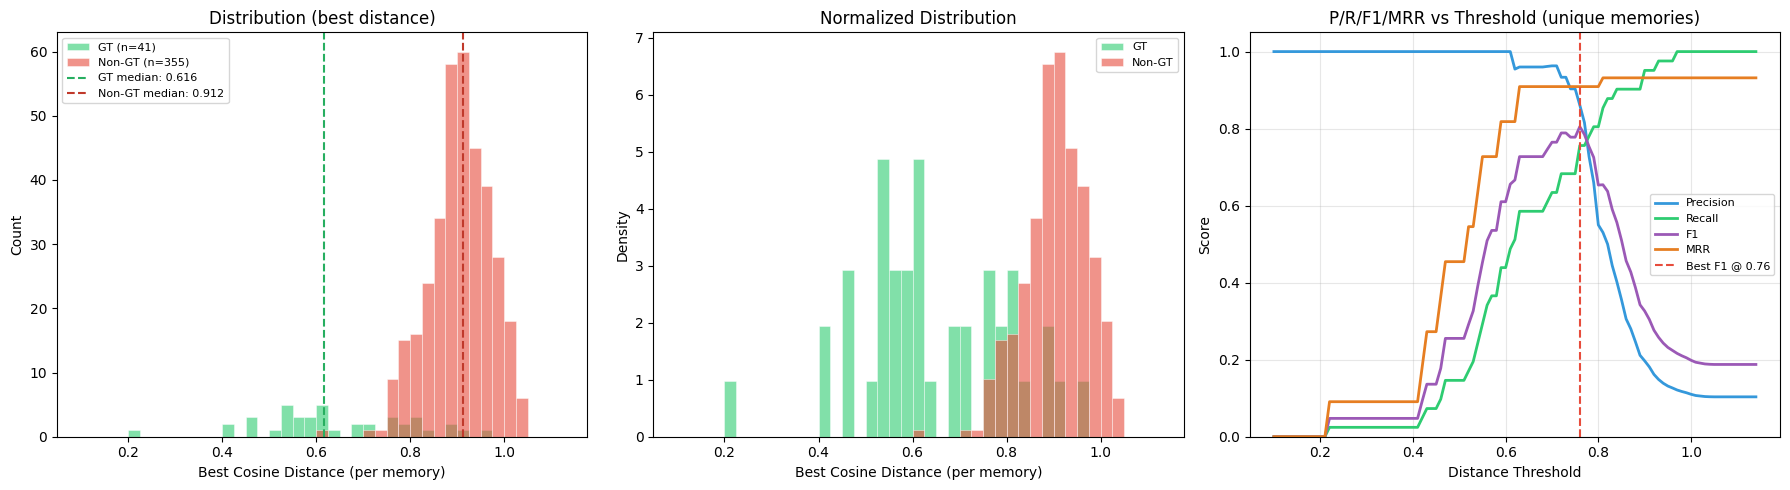


Optimal F1 threshold: 0.76
  F1:        0.805
  Precision: 0.861
  Recall:    0.756
  MRR:       0.909


In [28]:
# Histograms, normalized distribution, and threshold sweep (with MRR)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

bins = np.arange(0.1, 1.15, 0.025)

# Left: overlaid histograms (unique memories, best distance)
axes[0].hist(gt_best, bins=bins, alpha=0.6, label=f"GT (n={len(gt_best)})",
             color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[0].hist(non_gt_best, bins=bins, alpha=0.6, label=f"Non-GT (n={len(non_gt_best)})",
             color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[0].axvline(np.median(gt_best), color="#27ae60", linestyle="--", linewidth=1.5,
                label=f"GT median: {np.median(gt_best):.3f}")
axes[0].axvline(np.median(non_gt_best), color="#c0392b", linestyle="--", linewidth=1.5,
                label=f"Non-GT median: {np.median(non_gt_best):.3f}")
axes[0].set_xlabel("Best Cosine Distance (per memory)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution (best distance)")
axes[0].legend(fontsize=8)

# Center: normalized (density) histograms — useful for comparing shapes despite different sample sizes
axes[1].hist(gt_best, bins=bins, alpha=0.6, density=True,
             label="GT", color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[1].hist(non_gt_best, bins=bins, alpha=0.6, density=True,
             label="Non-GT", color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[1].set_xlabel("Best Cosine Distance (per memory)")
axes[1].set_ylabel("Density")
axes[1].set_title("Normalized Distribution")
axes[1].legend(fontsize=8)

# Right: P/R/F1/MRR vs threshold
# IMPORTANT: recall denominator must be ALL GT memories (including those never retrieved),
# not just those that appeared in search results. Missed memories are false negatives
# at every threshold.
#
# MRR at threshold: for each experiment, filter to memories within threshold (sorted by distance),
# compute reciprocal rank of first GT hit.
exp_thresholds = np.arange(0.10, 1.15, 0.01)
exp_precisions = []
exp_recalls = []
exp_f1_scores = []
exp_mrr_scores = []

for t in exp_thresholds:
    gt_acc = np.sum(gt_best <= t)
    non_gt_acc = np.sum(non_gt_best <= t)
    total_acc = gt_acc + non_gt_acc
    p = gt_acc / total_acc if total_acc > 0 else 1.0
    r = gt_acc / total_gt_memories if total_gt_memories > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    exp_precisions.append(p)
    exp_recalls.append(r)
    exp_f1_scores.append(f1)

    # MRR: computed per-experiment then averaged
    rrs = []
    for exp in experiments:
        gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))
        best_distances = {}
        for qr in exp.get("queries", []):
            for res in qr.get("results", []):
                mid = res["id"]
                d = res["distance"]
                if mid not in best_distances or d < best_distances[mid]:
                    best_distances[mid] = d
        # Filter by threshold and sort by distance
        accepted_sorted = sorted(
            [(mid, d) for mid, d in best_distances.items() if d <= t],
            key=lambda x: x[1]
        )
        rr = 0.0
        for rank, (mid, _) in enumerate(accepted_sorted, 1):
            if mid in gt_ids:
                rr = 1.0 / rank
                break
        rrs.append(rr)
    exp_mrr_scores.append(np.mean(rrs))

exp_precisions = np.array(exp_precisions)
exp_recalls = np.array(exp_recalls)
exp_f1_scores = np.array(exp_f1_scores)
exp_mrr_scores = np.array(exp_mrr_scores)

exp_best_f1_idx = np.argmax(exp_f1_scores)
exp_best_threshold = exp_thresholds[exp_best_f1_idx]

axes[2].plot(exp_thresholds, exp_precisions, label="Precision", color="#3498db", linewidth=2)
axes[2].plot(exp_thresholds, exp_recalls, label="Recall", color="#2ecc71", linewidth=2)
axes[2].plot(exp_thresholds, exp_f1_scores, label="F1", color="#9b59b6", linewidth=2)
axes[2].plot(exp_thresholds, exp_mrr_scores, label="MRR", color="#e67e22", linewidth=2)
axes[2].axvline(exp_best_threshold, color="#e74c3c", linestyle="--", linewidth=1.5,
                label=f"Best F1 @ {exp_best_threshold:.2f}")
axes[2].set_xlabel("Distance Threshold")
axes[2].set_ylabel("Score")
axes[2].set_title("P/R/F1/MRR vs Threshold (unique memories)")
axes[2].legend(fontsize=8)
axes[2].set_ylim(0, 1.05)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  F1:        {exp_f1_scores[exp_best_f1_idx]:.3f}")
print(f"  Precision: {exp_precisions[exp_best_f1_idx]:.3f}")
print(f"  Recall:    {exp_recalls[exp_best_f1_idx]:.3f}")
print(f"  MRR:       {exp_mrr_scores[exp_best_f1_idx]:.3f}")
if not_retrieved > 0:
    print(f"  NOTE: {not_retrieved} GT memories were never retrieved by any query (recall ceiling: {len(gt_best)/total_gt_memories:.1%})")

In [29]:
# Threshold table (unique memories, with MRR)
print(f"Threshold table (unique memories, best distance per memory):")
if not_retrieved > 0:
    print(f"NOTE: {not_retrieved} GT memories never retrieved — recall ceiling = {len(gt_best)/total_gt_memories:.1%}")
print()
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Accepted':>10} {'GT Kept':>8} {'GT Lost':>8}")
print("-" * 82)

for t in [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05]:
    gt_acc = int(np.sum(gt_best <= t))
    non_gt_acc = int(np.sum(non_gt_best <= t))
    total_acc = gt_acc + non_gt_acc
    p = gt_acc / total_acc if total_acc > 0 else 1.0
    r = gt_acc / total_gt_memories if total_gt_memories > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    gt_lost = total_gt_memories - gt_acc

    # MRR per-experiment at this threshold
    rrs = []
    for exp in experiments:
        gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))
        best_distances = {}
        for qr in exp.get("queries", []):
            for res in qr.get("results", []):
                mid = res["id"]
                d = res["distance"]
                if mid not in best_distances or d < best_distances[mid]:
                    best_distances[mid] = d
        accepted_sorted = sorted(
            [(mid, d) for mid, d in best_distances.items() if d <= t],
            key=lambda x: x[1]
        )
        rr = 0.0
        for rank, (mid, _) in enumerate(accepted_sorted, 1):
            if mid in gt_ids:
                rr = 1.0 / rank
                break
        rrs.append(rr)
    mrr = np.mean(rrs)

    marker = " <--" if abs(t - exp_best_threshold) < 0.015 else ""
    print(f"{t:>10.2f} {p:>10.3f} {r:>8.3f} {f1:>8.3f} {mrr:>8.3f} {total_acc:>10} {gt_acc:>8} {gt_lost:>8}{marker}")

Threshold table (unique memories, best distance per memory):

 Threshold  Precision   Recall       F1      MRR   Accepted  GT Kept  GT Lost
----------------------------------------------------------------------------------
      0.55      1.000    0.293    0.453    0.727         12       12       29
      0.60      1.000    0.439    0.610    0.818         18       18       23
      0.65      0.960    0.585    0.727    0.909         25       24       17
      0.70      0.963    0.634    0.765    0.909         27       26       15
      0.75      0.903    0.683    0.778    0.909         31       28       13 <--
      0.80      0.550    0.805    0.653    0.909         60       33        8
      0.85      0.356    0.902    0.510    0.932        104       37        4
      0.90      0.197    0.951    0.326    0.932        198       39        2
      0.95      0.132    0.976    0.232    0.932        304       40        1
      1.00      0.110    1.000    0.199    0.932        372       41   

In [30]:
# Per-experiment impact of applying the best threshold (with MRR)
print(f"Impact of threshold={exp_best_threshold:.2f} per experiment:\n")
print(f"{'Test Case':<55} {'Recall':>7} {'Prec':>7} {'F1':>7} {'MRR':>7} {'GT':>4} {'Kept':>5} {'Lost':>5}")
print("-" * 102)

per_exp_mrrs = []
for exp in experiments:
    tc_id = exp.get("test_case_id", "unknown")
    gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))

    # Collect unique retrieved IDs with their best (minimum) distance
    best_distances = {}  # memory_id -> min distance across all queries
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r["distance"]
            if mid not in best_distances or d < best_distances[mid]:
                best_distances[mid] = d

    # Apply threshold and sort by distance
    accepted_sorted = sorted(
        [(mid, d) for mid, d in best_distances.items() if d <= exp_best_threshold],
        key=lambda x: x[1]
    )
    accepted_ids = {mid for mid, _ in accepted_sorted}
    gt_accepted = accepted_ids & gt_ids
    gt_lost = gt_ids - accepted_ids

    r = len(gt_accepted) / len(gt_ids) if gt_ids else 0
    p = len(gt_accepted) / len(accepted_ids) if accepted_ids else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0

    # MRR: reciprocal rank of first GT hit in accepted results (sorted by distance)
    rr = 0.0
    for rank, (mid, _) in enumerate(accepted_sorted, 1):
        if mid in gt_ids:
            rr = 1.0 / rank
            break
    per_exp_mrrs.append(rr)

    print(f"{tc_id:<55} {r:>7.1%} {p:>7.1%} {f1:>7.3f} {rr:>7.3f} {len(gt_ids):>4} {len(gt_accepted):>5} {len(gt_lost):>5}")

    if gt_lost:
        for mid in sorted(gt_lost):
            d = best_distances.get(mid)
            d_str = f"{d:.4f}" if d is not None else "NOT RETRIEVED"
            print(f"  {'':55} Lost: {mid} (best d={d_str})")

print("-" * 102)
print(f"{'AVERAGE MRR':<55} {'':>7} {'':>7} {'':>7} {np.mean(per_exp_mrrs):>7.3f}")

Impact of threshold=0.76 per experiment:

Test Case                                                Recall    Prec      F1     MRR   GT  Kept  Lost
------------------------------------------------------------------------------------------------------
tc_review_10                                             100.0%  100.0%   1.000   1.000    5     5     0
tc_review_11                                              75.0%  100.0%   0.857   1.000    4     3     1
                                                          Lost: mem_8df897f58579 (best d=0.8304)
tc_review_1                                              100.0%  100.0%   1.000   1.000    3     3     0
tc_review_2                                                0.0%    0.0%   0.000   0.000    2     0     2
                                                          Lost: mem_13c005e3e7f9 (best d=0.8991)
                                                          Lost: mem_bd7e14fb86d7 (best d=0.8000)
tc_review_3                            

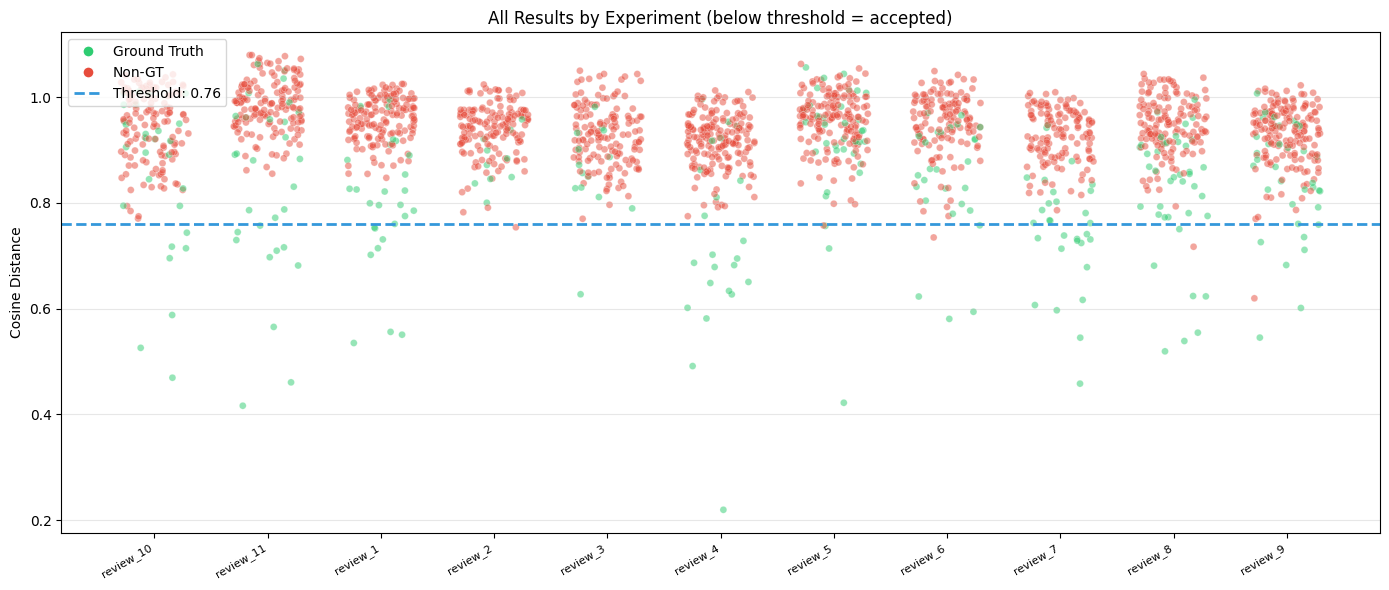

In [31]:
# Scatter plot: every result colored by ground truth status
fig, ax = plt.subplots(figsize=(14, 6))

# Group by experiment for x-axis positioning
exp_names = [e.get("test_case_id", "?").replace("tc_", "")[:30] for e in experiments]
x_positions = []
colors = []
distances_plot = []

for exp_idx, exp in enumerate(experiments):
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            # Add jitter for readability
            x_positions.append(exp_idx + np.random.uniform(-0.3, 0.3))
            distances_plot.append(r["distance"])
            colors.append("#2ecc71" if r["is_ground_truth"] else "#e74c3c")

ax.scatter(x_positions, distances_plot, c=colors, alpha=0.5, s=25, edgecolors="white", linewidth=0.3)
ax.axhline(exp_best_threshold, color="#3498db", linestyle="--", linewidth=2,
           label=f"Optimal threshold: {exp_best_threshold:.2f}")

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=8, label='Ground Truth'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=8, label='Non-GT'),
    Line2D([0], [0], color='#3498db', linestyle='--', linewidth=2, label=f'Threshold: {exp_best_threshold:.2f}'),
]
ax.legend(handles=legend_elements, loc="upper left")

ax.set_xticks(range(len(exp_names)))
ax.set_xticklabels(exp_names, rotation=30, ha="right", fontsize=8)
ax.set_ylabel("Cosine Distance")
ax.set_title("All Results by Experiment (below threshold = accepted)")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [32]:
# Analyze the current confidence buckets from db.py vs data-driven buckets
current_buckets = [
    ("high",     0.0,  0.5),
    ("medium",   0.5,  0.8),
    ("low",      0.8,  1.2),
    ("very_low", 1.2,  2.0),
]

print("Current confidence buckets (db.py) vs actual data (unique memories, best distance):\n")
print(f"{'Bucket':<10} {'Range':<15} {'GT Count':>10} {'Non-GT':>10} {'GT %':>8} {'Precision':>10}")
print("-" * 70)

for name, lo, hi in current_buckets:
    gt_in = int(np.sum((gt_best >= lo) & (gt_best < hi)))
    non_gt_in = int(np.sum((non_gt_best >= lo) & (non_gt_best < hi)))
    total_in = gt_in + non_gt_in
    gt_pct = gt_in / len(gt_best) * 100 if len(gt_best) > 0 else 0
    prec = gt_in / total_in if total_in > 0 else 0
    print(f"{name:<10} [{lo:.1f}, {hi:.1f}){'':<5} {gt_in:>10} {non_gt_in:>10} {gt_pct:>7.1f}% {prec:>10.1%}")

print(f"\nRecommendation: Update confidence buckets based on data distribution.")
print(f"The optimal F1 threshold ({exp_best_threshold:.2f}) should be the cutoff between 'accepted' and 'rejected'.")

Current confidence buckets (db.py) vs actual data (unique memories, best distance):

Bucket     Range             GT Count     Non-GT     GT %  Precision
----------------------------------------------------------------------
high       [0.0, 0.5)               6          0    14.6%     100.0%
medium     [0.5, 0.8)              27         27    65.9%      50.0%
low        [0.8, 1.2)               8        328    19.5%       2.4%
very_low   [1.2, 2.0)               0          0     0.0%       0.0%

Recommendation: Update confidence buckets based on data distribution.
The optimal F1 threshold (0.76) should be the cutoff between 'accepted' and 'rejected'.


In [33]:
# Final summary and recommendation (with MRR)
print("=" * 70)
print("THRESHOLD ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nTotal GT memories: {total_gt_memories}")
print(f"GT retrieved:      {len(gt_best)} ({len(gt_best)/total_gt_memories:.1%})")
print(f"GT not retrieved:  {not_retrieved}")
print(f"Non-GT retrieved:  {len(non_gt_best)}")
print(f"\nOptimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  P={exp_precisions[exp_best_f1_idx]:.1%}, R={exp_recalls[exp_best_f1_idx]:.1%}, "
      f"F1={exp_f1_scores[exp_best_f1_idx]:.3f}, MRR={exp_mrr_scores[exp_best_f1_idx]:.3f}")

print(f"\n--- Key Tradeoff Points ---")
for t, label in [(0.80, "aggressive"), (exp_best_threshold, "optimal F1"), (0.95, "conservative")]:
    idx = np.argmin(np.abs(exp_thresholds - t))
    gt_lost = total_gt_memories - int(np.sum(gt_best <= t))
    print(f"  t={t:.2f} ({label:>12}): P={exp_precisions[idx]:.1%}, R={exp_recalls[idx]:.1%}, "
          f"F1={exp_f1_scores[idx]:.3f}, MRR={exp_mrr_scores[idx]:.3f}, GT lost={gt_lost}")

print(f"\n--- Recommendation ---")
print(f"The GT and non-GT distributions overlap significantly (GT median={np.median(gt_best):.3f}, "
      f"non-GT median={np.median(non_gt_best):.3f}).")
print(f"A single distance threshold cannot cleanly separate them.")
print(f"")
print(f"Practical options:")
print(f"  1. Use threshold={exp_best_threshold:.2f} as DEFAULT_DISTANCE_THRESHOLD for best F1")
print(f"  2. Use threshold=0.95 to keep ~all GT while removing the worst noise")
print(f"  3. Combine threshold with additional signals (RRF scoring, re-ranking)")
print(f"     to improve separation beyond what distance alone provides")
print("=" * 70)

THRESHOLD ANALYSIS SUMMARY

Total GT memories: 41
GT retrieved:      41 (100.0%)
GT not retrieved:  0
Non-GT retrieved:  355

Optimal F1 threshold: 0.76
  P=86.1%, R=75.6%, F1=0.805, MRR=0.909

--- Key Tradeoff Points ---
  t=0.80 (  aggressive): P=55.0%, R=80.5%, F1=0.653, MRR=0.909, GT lost=8
  t=0.76 (  optimal F1): P=86.1%, R=75.6%, F1=0.805, MRR=0.909, GT lost=10
  t=0.95 (conservative): P=13.2%, R=97.6%, F1=0.232, MRR=0.932, GT lost=1

--- Recommendation ---
The GT and non-GT distributions overlap significantly (GT median=0.616, non-GT median=0.912).
A single distance threshold cannot cleanly separate them.

Practical options:
  1. Use threshold=0.76 as DEFAULT_DISTANCE_THRESHOLD for best F1
  2. Use threshold=0.95 to keep ~all GT while removing the worst noise
  3. Combine threshold with additional signals (RRF scoring, re-ranking)
     to improve separation beyond what distance alone provides
